In [1]:
import os
import itertools

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from gam_follow_up import config, utils
from gamtools import segregation

# Mapping statistics

In [3]:
multiplex_mapping = pd.read_csv(
    config.in_data_raw('multiplex-gam-data/gamtools_output/merged_stats.txt'),
    delim_whitespace=True)

In [4]:
mapping_3np = []
expt_nos = np.sort(multiplex_mapping.expt_no.unique())
for expt in expt_nos:
    expt_map = multiplex_mapping.loc[
        np.logical_and(
            multiplex_mapping.expt_no == expt,
            multiplex_mapping.optimization_only == False),
        'Percent_mapped_reads'].values
    mapping_3np.append(expt_map)

In [5]:
multiplex_mapping[multiplex_mapping.optimization_only == False].shape

(330, 27)

In [6]:
multiplex_mapping[np.logical_and(np.logical_and(
        multiplex_mapping.optimization_only == False,
        multiplex_mapping.Percent_mapped_reads > 15),
                 multiplex_mapping.tube_contents == '4np')].shape

(249, 27)

In [7]:
singlet_mapping = pd.read_csv(
    config.in_data_raw('1np-gam-data/gamtools_output/merged_stats.txt'),
    delim_whitespace=True).Percent_mapped_reads.values

In [8]:
def dotplot(values, bounds=(-0.15,0.15), label=None,
            median=True, x_pos=None, horizontal=False, **kwargs):
    
    if x_pos is None:
        x = list(itertools.chain(*[[i]*len(v) for i,v in enumerate(values)]))
        x_ix = range(np.max(x)+1)

    else:
        x = list(itertools.chain(*[[x_pos[i]]*len(v) for i,v in enumerate(values)]))
        x_ix = x_pos
    
    x = np.array(x) + np.random.uniform(bounds[0], bounds[1], len(x))

    y = np.concatenate(values)
    
    if horizontal:
        x, y = y, x
 
    plt.scatter(x, y, label=label, **kwargs)
    
    if median:
        mean_expr = [np.median(y[(x == i).nonzero()[0]]) for i in x_ix]
        plt.plot(x_ix, mean_expr)

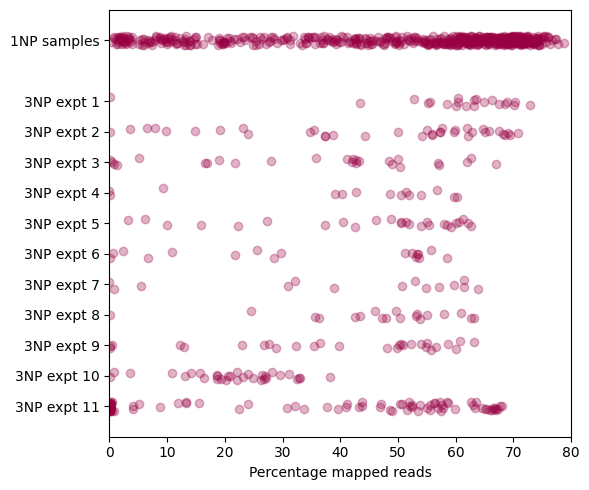

In [9]:
plt.figure(figsize=(6,5), facecolor='white')

_b = dotplot(list(reversed([singlet_mapping] + [np.array([])] + mapping_3np)),
                      alpha=0.3, color='#980043', horizontal=True, median=False)

plt.xlabel('Percentage mapped reads')

n_exp = len(mapping_3np)

plt.yticks(list(range(n_exp)) + [n_exp+1],
           ['3NP expt {}'.format(e) for e in reversed(expt_nos)
           ] + ['1NP samples'])

plt.xlim(0, 80)
plt.ylim(-1,13)
plt.tight_layout()


# Coverage statistics

In [10]:
coverage_all = []
for expt in expt_nos:
    expt_coverage = 100 * multiplex_mapping.loc[
        utils.chain_and(multiplex_mapping.expt_no == expt,
                        multiplex_mapping.Percent_mapped_reads > 15,
                        multiplex_mapping.optimization_only == False),
        'Genome_coverage'].values
    coverage_all.append(expt_coverage)

In [11]:
mesc_1NP_40kb = segregation.open_segregation(
    config.in_data_raw('1np-gam-data/gamtools_output/segregation_at_40kb.passed_qc.table'))

mesc_1NP_40kb_coverage = (100 * mesc_1NP_40kb.mean()).values

mesc_4NP_40kb_in_silico_coverage = (100 * utils.get_merged(mesc_1NP_40kb, 3).mean()).values

coverage_1np = [mesc_1NP_40kb_coverage, mesc_4NP_40kb_in_silico_coverage]

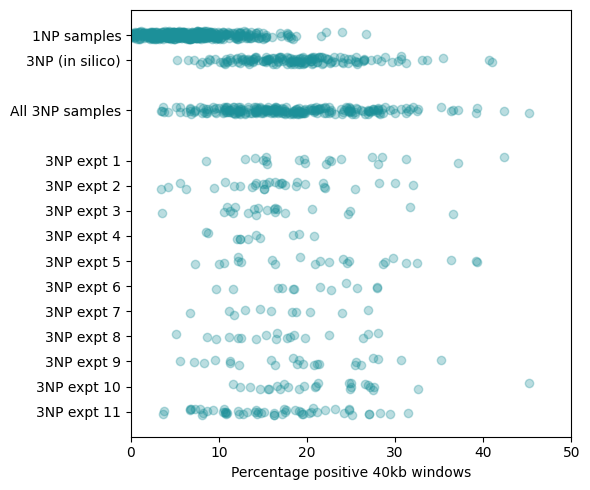

In [15]:
plt.figure(figsize=(6,5), facecolor='white')

_b = dotplot(list(reversed(coverage_1np + [np.array([])] + [np.concatenate(coverage_all)] + [np.array([])] + coverage_all)),
                      alpha=0.3, color='#1c9099', horizontal=True, median=False)


plt.xlabel('Percentage positive 40kb windows')

n_exp = len(coverage_all)

plt.yticks(list(range(n_exp)) + [n_exp+1, n_exp+3, n_exp+4],
           ['3NP expt {}'.format(e) for e in range(len(coverage_all), 0, -1)
           ] + ['All 3NP samples', '3NP (in silico)', '1NP samples'])

plt.xlim(0, 50)
plt.ylim(-1,16)
plt.tight_layout()
